In [1]:
print('starting')
%%time
# for development, changes in other modules have to be reloaded to reflect changes
%load_ext autoreload
%autoreload 1

print('pandas')
import pandas as pd 
print('numpy')
import numpy as np 
print('matplotlib')
from matplotlib import pyplot as plt 
print('sbn')
import seaborn as sbn 
print('os/sys')
import os, sys
print('simpleitk')
import SimpleITK as sitk

print('here')
# scripts found in ./workflow/libs
sys.path.append('./workflow/libs/')
%aimport utils
%aimport config
%aimport segment 
%aimport match 
%aimport missingness 
%aimport register 
%aimport evaluate 
%aimport qc 

pandas
numpy
matplotlib
sbn
os/sys
simpleitk
here
CPU times: user 867 ms, sys: 456 ms, total: 1.32 s
Wall time: 1.6 s


# Overview 

In [2]:
img_file_names = os.listdir(config.image_dir_path)
parsed_names = pd.DataFrame([utils.parse_file_name(x) for x in img_file_names])
parsed_names.head()

round                    protein slide_name        date scan_id    scene  \
0    R2           PCNA.AR.ER.GATA3         S3  2020-01-23   13492  Scene-2   
1    R1  H3K27me3.CCNB1.CCND1.Ki67         S3  2020-01-22   13485  Scene-1   
2    R1  H3K27me3.CCNB1.CCND1.Ki67         S3  2020-01-22   13485   Scene3   
3    R1  H3K27me3.CCNB1.CCND1.Ki67         S3  2020-01-22   13485  Scene-1   
4    R2           PCNA.AR.ER.GATA3         S3  2020-01-23   13492  Scene-2   

  color_channel note file_type  \
0            c4  ORG       tif   
1            c3  ORG       tif   
2            c2  ORG       tif   
3            c5  ORG       tif   
4            c3  ORG       tif   

                                            original  
0  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene...  
1  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13...  
2  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13...  
3  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13...  
4  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene...

# Choose slide, scene

In [3]:
slides = parsed_names.slide_name.unique()
_ = [print(f'{i} : {x}') for i,x in enumerate(slides)]
print()
slide_in = input('please choose the slide to use [use integer]:  ')
slide_choice = slides[int(slide_in)]
print('slide name selected:', slide_choice)

parsed_names2 = parsed_names[parsed_names.slide_name == slide_choice]
print('shape', parsed_names2.shape)

0 : S3

please choose the slide to use [use integer]:  0
slide name selected: S3
shape (45, 10)


In [4]:
scenes = parsed_names2.scene.unique()

_ = [print(f'{i} : {x}') for i,x in enumerate(scenes)]
print()
scene_in = input('please choose the scene to use [use integer]:  ')
scene_choice = scenes[int(scene_in)]
print('slide name selected:', scene_choice)

parsed_names3 = parsed_names2[parsed_names2.scene == scene_choice]
print('shape', parsed_names3.shape)

0 : Scene-2
1 : Scene-1
2 : Scene3
3 : Scene-3

please choose the scene to use [use integer]:  1
slide name selected: Scene-1
shape (15, 10)


# Load images 

This can take a few minutes, grab a cup of tea. 

In [5]:
%%time
imgs = {}
i = 1
for path in parsed_names3.original.values: 
    print(f'progress: {i}/{parsed_names3.original.values.shape[0]}', end='\r')
    imgs[path] = sitk.ReadImage(config.image_dir_path + path)
    i+=1

CPU times: user 5.85 s, sys: 20.8 s, total: 26.7 s
Wall time: 1min 24s


# Segment R0 cores 

we'll down-sample our images to speed up the processing. 

shape of downsampled R0: (2044, 2040)


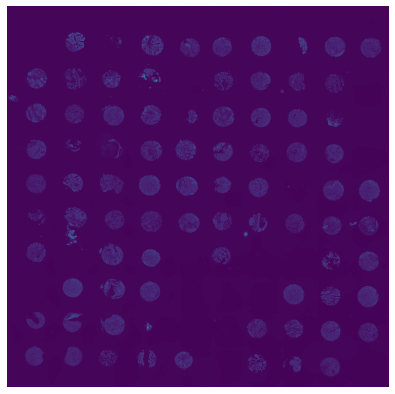

In [8]:
R0_dapi_name = parsed_names3[(parsed_names3.color_channel == 'c1') & (parsed_names3['round'] == 'R0')]

R0_dapi_full = imgs[R0_dapi_name.original.item()]
R0_dapi = R0_dapi_full[::config.downsample_proportion,::config.downsample_proportion]

print('shape of downsampled R0:', R0_dapi.GetSize())

utils.myshow(R0_dapi)

rescaling img..
applying gaussing blur...


<Figure size 432x288 with 0 Axes>

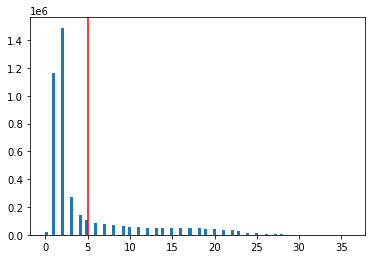

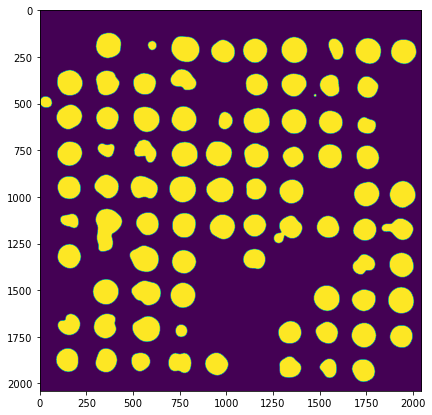

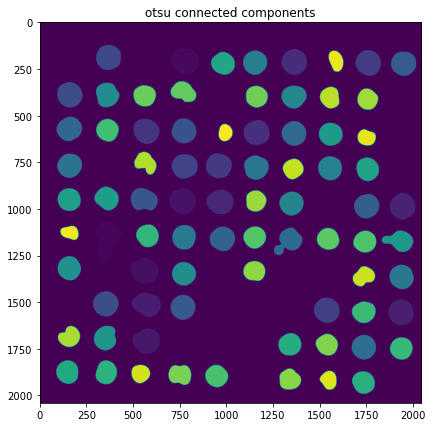

CPU times: user 4 s, sys: 39.5 ms, total: 4.04 s
Wall time: 1.85 s


center_x  center_y  width  height  Volume (nm^3)  Elongation  Flatness  \
1       298      1065    141     228       0.926114    1.913157  1.913157   
2       703       141    150     137       0.693149    1.125757  1.125757   
3       481      1262    154     140       0.690234    1.137847  1.137847   
4       693       891    141     139       0.657068    1.018398  1.018398   
5       495      1640    147     136       0.648829    1.098178  1.098178   

   Oriented Bounding Box Minimum Size(nm)  \
1                                0.924270   
2                                0.898477   
3                                0.888489   
4                                0.907621   
5                                0.886828   

   Oriented Bounding Box Maximum Size(nm)  Intensity Mean  \
1                                1.500159       17.234352   
2                                0.992485       17.789284   
3                                1.036996       17.397564   
4                                0.926348       18.084105   
5                                0.959508       17.597187   

   Intensity Standard Deviation  Intensity Skewness  component  
1                     23.190951            2.367878          1  
2                     20.787581            1.649660          2  
3                     15.824184            1.013036          3  
4                     14.938719            0.672403          4  
5                     15.842310            1.145416          5

In [88]:
%%time
R0_dapi_stats, shape_stats = segment.segment_dapi_round(R0_dapi, plot=True)
R0_dapi_stats.head()

# Choose core 

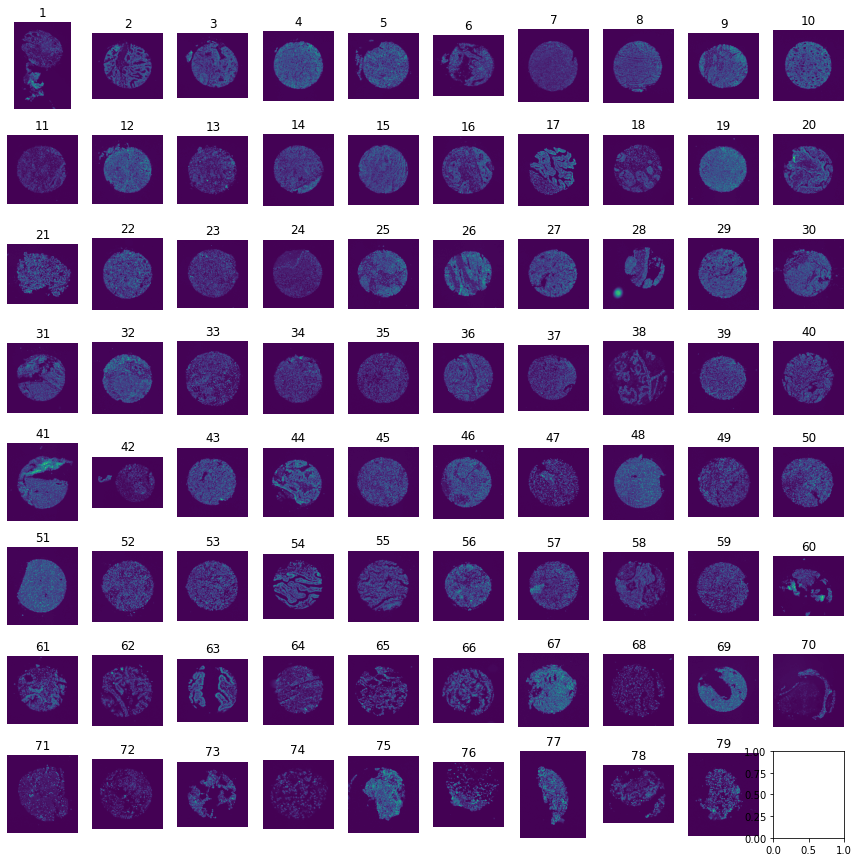

In [89]:
segment.plot_cores(R0_dapi, R0_dapi_stats)

which core would you like to use? (integer):  41
you chose:  41


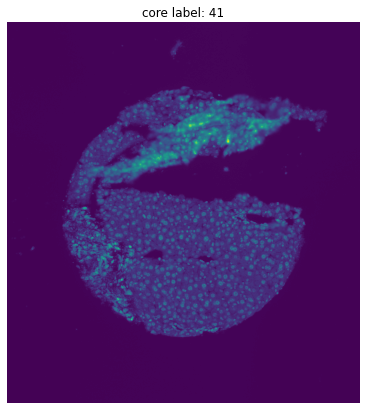

In [61]:
core_in = int(input('which core would you like to use? (integer):  '))
print('you chose: ', core_in)

R0_dapi_core = segment.select_core(R0_dapi_full, core_in, R0_dapi_stats, scale=config.downsample_proportion)

utils.myshow(R0_dapi_core, f'core label: {core_in}')

# match core labels across rounds 

In [96]:
%%time

res = match.get_all_rounds_core_statistics(parsed_names3, imgs, verbose=True)

processing:  R0_AF488.AF555.AF647.AF750_S3_2020_01_21__13471-Scene-1_c1_ORG.tif
processing:  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1_c1_ORG.tif
processing:  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13485-Scene-1_c1_ORG.tif
CPU times: user 8.28 s, sys: 136 ms, total: 8.42 s
Wall time: 1.77 s


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

plotting centers:  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13485-Scene-1_c3_ORG.tif
plotting centers:  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13485-Scene-1_c5_ORG.tif
plotting centers:  R0_AF488.AF555.AF647.AF750_S3_2020_01_21__13471-Scene-1_c1_ORG.tif
plotting centers:  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13485-Scene-1_c2_ORG.tif
plotting centers:  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1_c4_ORG.tif
plotting centers:  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1_c5_ORG.tif
plotting centers:  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13485-Scene-1_c4_ORG.tif
plotting centers:  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1_c3_ORG.tif
plotting centers:  R0_AF488.AF555.AF647.AF750_S3_2020_01_21__13471-Scene-1_c5_ORG.tif
plotting centers:  R0_AF488.AF555.AF647.AF750_S3_2020_01_21__13471-Scene-1_c4_ORG.tif
plotting centers:  R0_AF488.AF555.AF647.AF750_S3_2020_01_21__13471-Scene-1_c3_ORG.tif
plotting centers:  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1

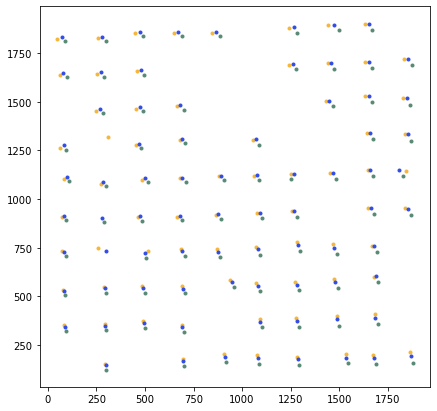

In [97]:
plt.figure(figsize=(7,7))

for i, name in enumerate(parsed_names3.original.values):
    print('plotting centers: ', name)
    rgb = np.random.rand(3)
    temp = res[res.img_name == name]
    plt.plot(temp.center_x, temp.center_y, c=rgb, marker='.', linestyle='None')
    
plt.show()

In [98]:
R0_nclus = res[lambda x: x['round']=='R0'].shape[0]
R1_nclus = res[lambda x: x['round']=='R1'].shape[0]
R2_nclus = res[lambda x: x['round']=='R2'].shape[0]

print('number of clusters in each round:', (R0_nclus, R1_nclus, R2_nclus))

number of clusters in each round: (79, 80, 80)


In [99]:
cluster_labels = match.match_cores_across_rounds(res)
res = res.assign(cluster = cluster_labels)

using clustering method: dbscan


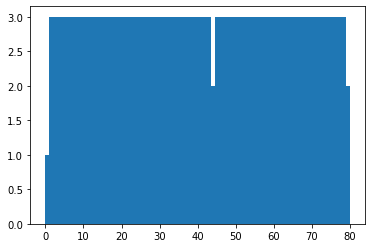

clusters with missing cores: [ 1 45 81]


In [100]:
plt.figure()
plt.hist(cluster_labels, bins=len(np.unique(cluster_labels)))
plt.show()

num_of_rounds = parsed_names['round'].unique().shape[0]

uniq, labels = np.unique(cluster_labels + 1, return_counts=True)
print('clusters with missing cores:', np.unique(uniq[labels < num_of_rounds]))

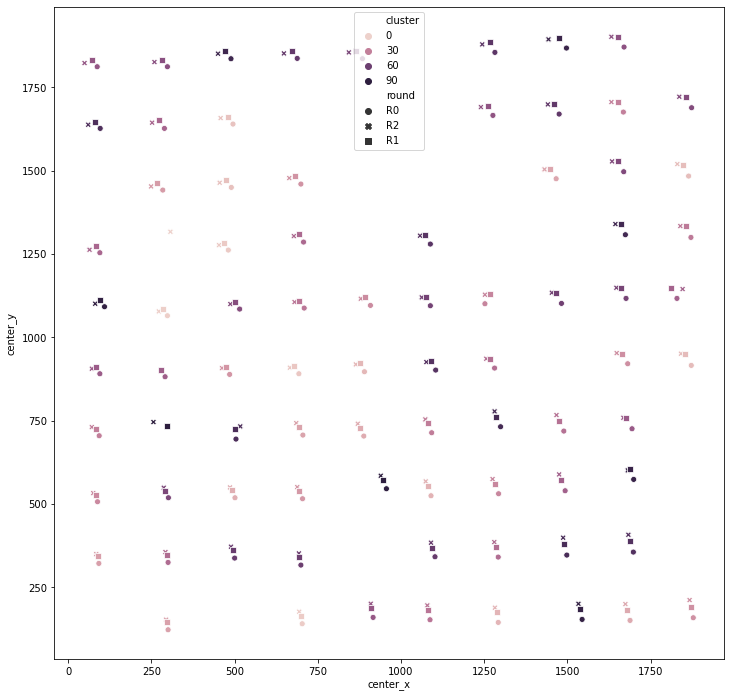

In [101]:
plt.figure(figsize=(12,12))
sbn.scatterplot(x='center_x', y='center_y', hue='cluster', style='round', data=res)
plt.show()

## Inspect the matched data

cluster choice: 41


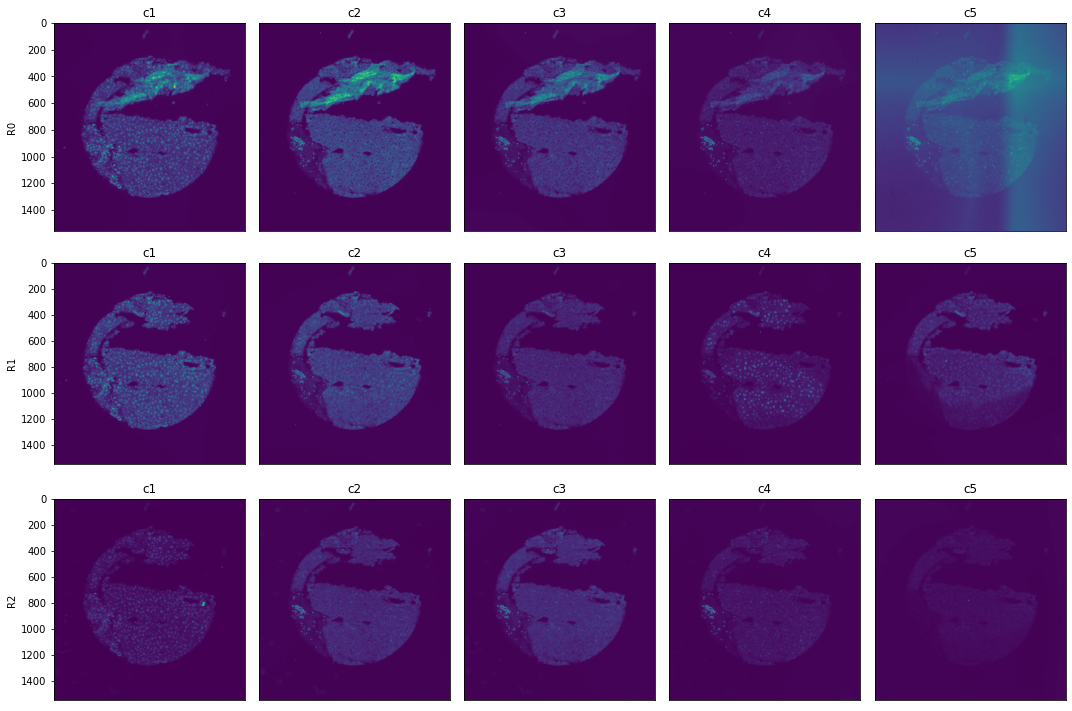

In [102]:
cluster_choice = res[(res['round'] == 'R0') & (res['component'] == core_in)].cluster.item()
print('cluster choice:', cluster_choice)

res_choice = res[res.cluster == cluster_choice]
res_choice.head()

selected_cores = {x:{'unregistered':{}} for x in res_choice['round'].unique()}

f,axes = plt.subplots(num_of_rounds, 5, figsize=(15,10))

for ax,(i, row) in zip(axes.flat, parsed_names3.sort_values(['round', 'color_channel']).reset_index(drop=True).iterrows()): 
    
    print('progress:', i, end='\r')
    temp = res_choice[(res_choice.cluster == cluster_choice) & (res_choice['round'] == row['round'])]
    
    if temp.shape[0] == 0: 
        print('no image')
        continue
        #selected_cores[row['round']]['unregistered'][row.color_channel] = None
        #continue
        
    _core = segment.select_core(imgs[row.original], temp.component, temp, scale=config.downsample_proportion)
    
    _core.SetOrigin((0,0))
    
    selected_cores[row['round']]['unregistered'][row.color_channel] = _core
    
    utils.myshow(_core, ax=ax)
    
    ax.set_title(row.color_channel)
    if row.color_channel == 'c1': 
        ax.set_ylabel(row['round'])
        ax.axes.yaxis.set_visible(True)
    
plt.tight_layout()
plt.show()

# Register Dapi Images 


In [110]:
%%time
print('generating registration function...')
for R in selected_cores.keys(): 
    if R == 'R0': continue
    print('#'*20)
    print('ROUND:', R)
    print('#'*20)
        
    selected_cores[R]['reg_Tx'] = register.get_registration_transform(selected_cores['R0']['unregistered']['c1'], 
                                                                      selected_cores[R]['unregistered']['c1'], 
                                                                      verbose=True)

generating registration function...
####################
ROUND: R2
####################
-------
itk::simple::Transform
 TranslationTransform (0x564369774150)
   RTTI typeinfo:   itk::TranslationTransform<double, 2u>
   Reference Count: 2
   Modified Time: 1212395
   Debug: Off
   Object Name: 
   Observers: 
     none
   Offset: [0.011067, -0.01754]

Optimizer stop condition: RegularStepGradientDescentOptimizerv4: Gradient magnitude tolerance met after 26 iterations. Gradient magnitude (5.68669e-05) is less than gradient magnitude tolerance (0.0001).
 Iteration: 27
 Metric value: -0.49114899741141904
####################
ROUND: R1
####################
-------
itk::simple::Transform
 TranslationTransform (0x56436815c290)
   RTTI typeinfo:   itk::TranslationTransform<double, 2u>
   Reference Count: 2
   Modified Time: 1214012
   Debug: Off
   Object Name: 
   Observers: 
     none
   Offset: [0.0110408, -0.0164587]

Optimizer stop condition: RegularStepGradientDescentOptimizerv4: Gradien

In [111]:
%%time
print('preforming transformation...')
for R in selected_cores.keys(): 
    selected_cores[R]['registered'] = {}
    for c in selected_cores[R]['unregistered'].keys():
        if R == 'R0':
            # for convenience - fixed image
            selected_cores[R]['registered'][c] = selected_cores[R]['unregistered'][c]
        else:
            print('registering:', (R, c))
            # trasformed each channel using the dapi registration 
            selected_cores[R]['registered'][c] = register.preform_transformation(selected_cores['R0']['unregistered']['c1'],
                                                                                     selected_cores[R]['unregistered']['c1'], 
                                                                                     selected_cores[R]['reg_Tx'])



preforming transformation...
registering: ('R2', 'c1')
registering: ('R2', 'c2')
registering: ('R2', 'c3')
registering: ('R2', 'c4')
registering: ('R2', 'c5')
registering: ('R1', 'c1')
registering: ('R1', 'c2')
registering: ('R1', 'c3')
registering: ('R1', 'c4')
registering: ('R1', 'c5')
CPU times: user 890 ms, sys: 11.5 ms, total: 902 ms
Wall time: 165 ms


# Registration visualization 

We will combine the first 3 Dapi Rounds into a single image (round per channel). White indicates overlapping pixel intensities. Any non-white indicates differences in dapi image registrations. 

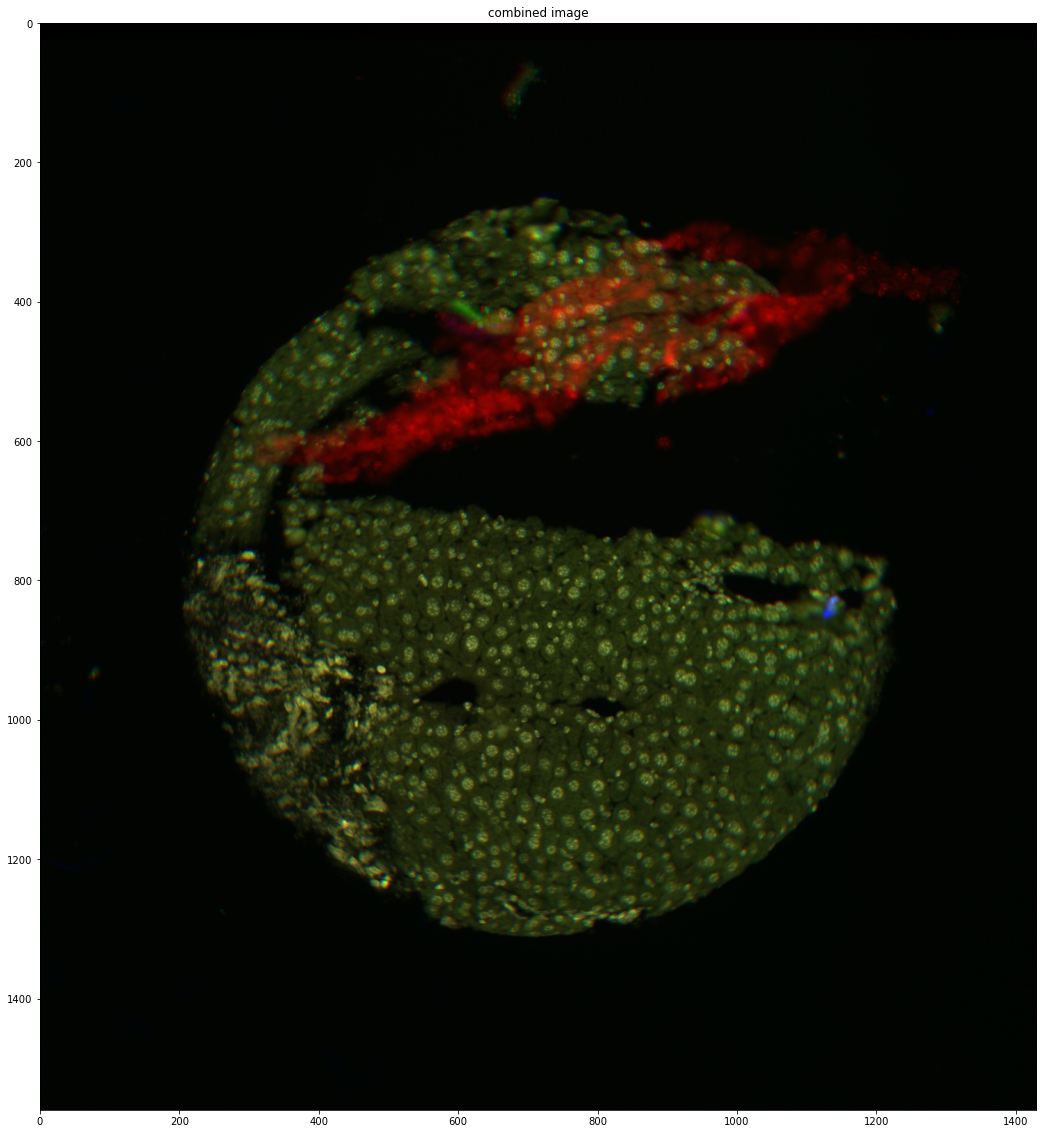

In [112]:
sigm1 = sitk.Cast(sitk.RescaleIntensity(selected_cores['R0']['registered']['c1']), sitk.sitkUInt8)
sigm2 = sitk.Cast(sitk.RescaleIntensity(selected_cores['R1']['registered']['c1']), sitk.sitkUInt8)
sigm3 = sitk.Cast(sitk.RescaleIntensity(selected_cores['R2']['registered']['c1']), sitk.sitkUInt8)

cimg = sitk.Compose(sigm1, sigm2, sigm3)

plt.figure(figsize=(20,20))
plt.title('combined image')
plt.imshow(sitk.GetArrayViewFromImage(cimg)) 
plt.show()

# Zoom in for better clarity

Change `wsize` below to change magnification

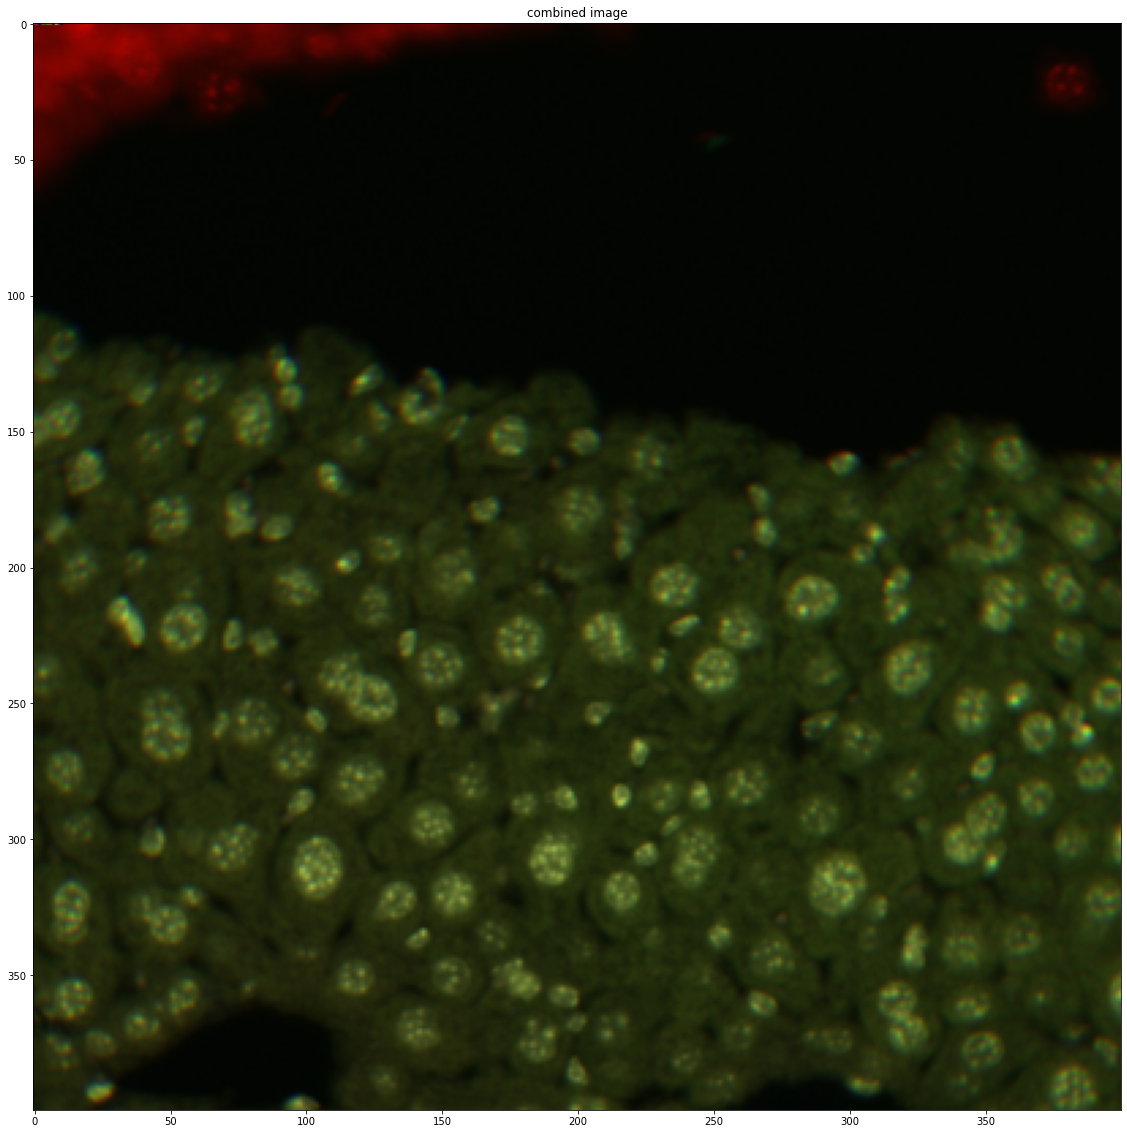

In [113]:
plt.figure(figsize=(20,20))
plt.title('combined image')

wsize = 200
x,y = cimg.GetSize()
plt.imshow(sitk.GetArrayViewFromImage(cimg[int(x/2-wsize):int(x/2+wsize), int(y/2-wsize):int(y/2+wsize)])) 
plt.show()

# Evaluating Registration 

To do this, we will follow the steps below:

1. Apply detailed binary segmentation; ideally we want cell level features 

2. Apply transformation from (1) to each registered DAPI image

3. Compare each subsequent registration mask and calculate success metrics 


## Below is the R0-DAPI image segmentation 

Inspect this, it should have decent cell level features. 

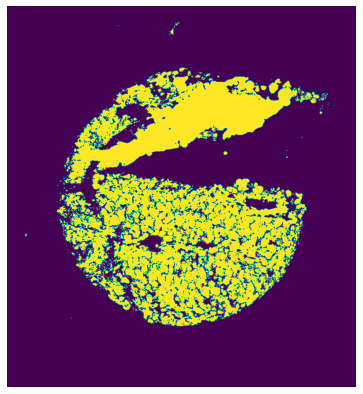

In [114]:
R0_dapi_seg = segment.perform_otsu_threshold(selected_cores['R0']['registered']['c1'])
utils.myshow(R0_dapi_seg)

Round: R0 -> R0
review the segmentations to make sure the look appropriate for comparison...


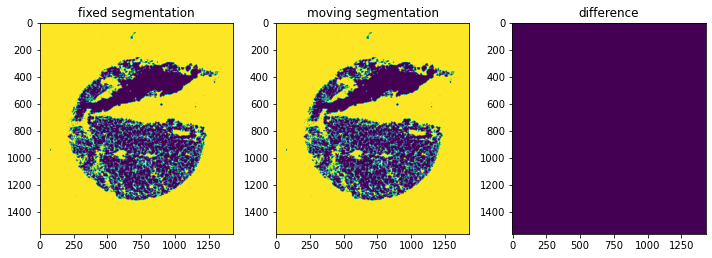

Round: R2 -> R0
review the segmentations to make sure the look appropriate for comparison...


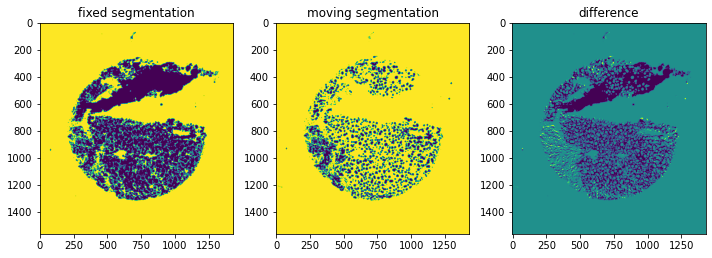

Round: R1 -> R0
review the segmentations to make sure the look appropriate for comparison...


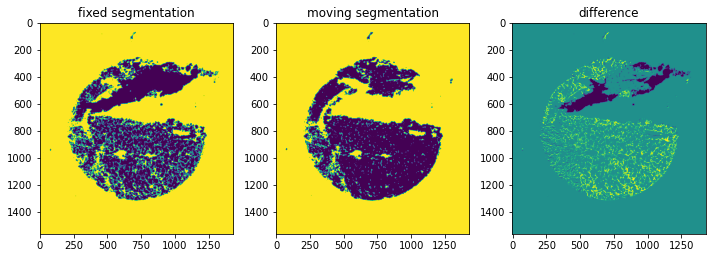

name  jacaard_coef  dice_coef  volume_similarity  false_neg_err  \
0  R0->R0;core-41      1.000000   1.000000           0.000000       0.000000   
1  R2->R0;core-41      0.315521   0.479690           0.902280       0.126026   
2  R1->R0;core-41      0.710704   0.830891          -0.050023       0.189384   

   false_pos_err  hausdorff_dist  
0       0.000000        0.000000  
1       0.669439        0.162511  
2       0.147794        0.141413

In [115]:
_res = []
for R in selected_cores.keys():
    print(f'Round: {R} -> R0')
    _res.append(evaluate.eval_registration(selected_cores['R0']['registered']['c1'],
                                           selected_cores[R]['registered']['c1'], 
                                           f'{R}->R0;core-{core_in}'))

res = pd.DataFrame(_res, index=range(len(_res)))
res.head()